# CNN on GPU: Cat vs Dog Classifier
> A lightweight yet GPU-intensive demo to show off parallelism, filters, and fast training

## Goal
Train a Convolutional Neural Network (CNN) to classify images of cats vs dogs using GPU acceleration. This helps showcase:
- The parallel nature of convolutions.
- How GPUs drastically reduce training time.
- Visual understanding of filters and feature maps.

## Dataset
Use TensorFlow’s *cats_vs_dogs* dataset:

In [1]:
import tensorflow_datasets as tfds
(train_ds, val_ds), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.L0V18N_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


## Preprocessing
Resize and normalize for better training:

In [2]:
import tensorflow as tf

IMG_SIZE = 128

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image, label

train = train_ds.map(format_image).batch(32).prefetch(1)
val = val_ds.map(format_image).batch(32).prefetch(1)

## CNN Architecture
A basic yet effective CNN:

In [3]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, 3, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Train on GPU

In [4]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train, validation_data=val, epochs=5)


Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 550s 941ms/step - accuracy: 0.5998 - loss: 0.6584 - val_accuracy: 0.6922 - val_loss: 0.5923
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 555s 953ms/step - accuracy: 0.7540 - loss: 0.5061 - val_accuracy: 0.7350 - val_loss: 0.5182
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 541s 929ms/step - accuracy: 0.8030 - loss: 0.4231 - val_accuracy: 0.7528 - val_loss: 0.5064
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 547s 940ms/step - accuracy: 0.8375 - loss: 0.3621 - val_accuracy: 0.7743 - val_loss: 0.5173
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 546s 938ms/step - accuracy: 0.8725 - loss: 0.2926 - val_accuracy: 0.8033 - val_loss: 0.4990


# Visualisations

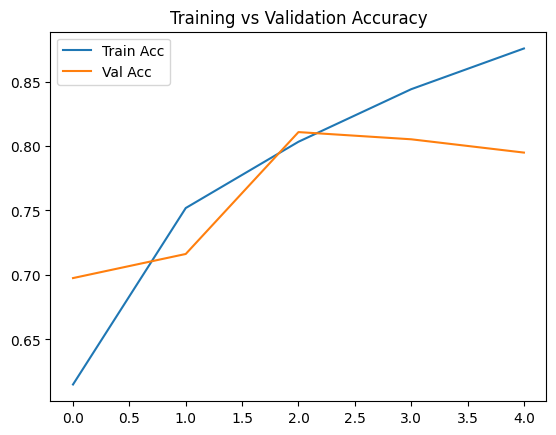

In [6]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

Filter shape: (3, 3, 3, 32)


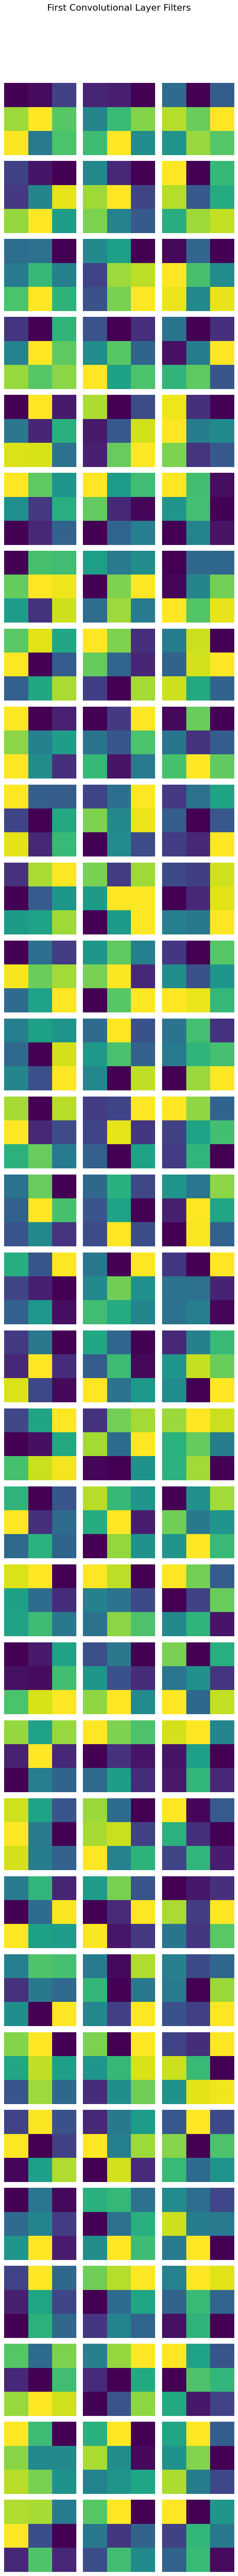

In [7]:
# Get filters (weights) of the first convolutional layer
filters, biases = model.layers[0].get_weights()

print("Filter shape:", filters.shape)  # (kernel_height, kernel_width, input_channels, num_filters)

# Normalize filter values to 0–1 for visualization
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

num_filters = filters.shape[3]
num_channels = filters.shape[2]

# Plot filters
fig, axes = plt.subplots(nrows=num_filters, ncols=num_channels, figsize=(num_channels * 2, num_filters * 2))
fig.suptitle("First Convolutional Layer Filters", fontsize=16)

for i in range(num_filters):
    for j in range(num_channels):
        ax = axes[i, j] if num_filters > 1 else axes[j]
        ax.imshow(filters[:, :, j, i], cmap='viridis')
        ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()


##  Sample Prediction

In [8]:
# Take one batch of validation data
for images, labels in val.take(1):
    sample_images = images.numpy()
    sample_labels = labels.numpy()
    break


In [9]:
# Model outputs probabilities (sigmoid)
predictions = model.predict(sample_images)

# Convert probabilities to class labels (0 = Cat, 1 = Dog)
predicted_classes = (predictions > 0.5).astype("int32").flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


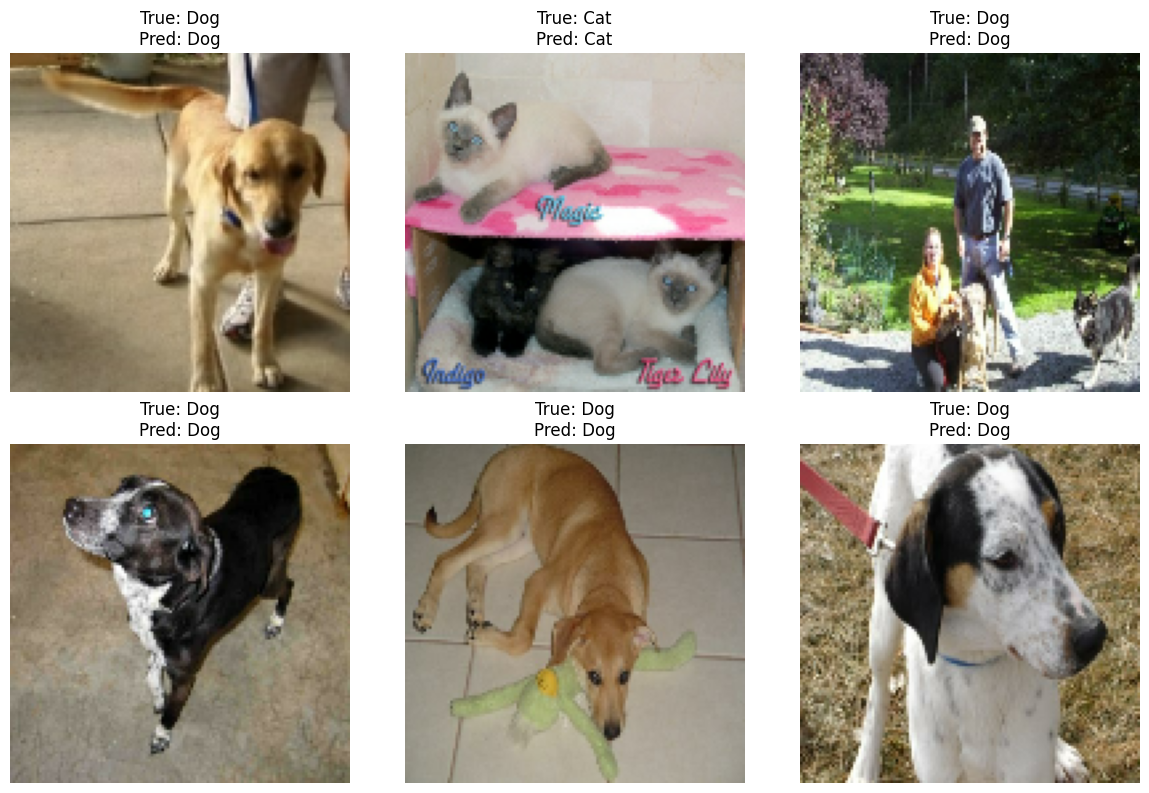

In [10]:
class_names = ['Cat', 'Dog']

plt.figure(figsize=(12, 8))

for i in range(6):  # Display first 6 predictions
    plt.subplot(2, 3, i+1)
    plt.imshow(sample_images[i])
    plt.title(f"True: {class_names[sample_labels[i]]}\nPred: {class_names[predicted_classes[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()